# sub_similarity

In [11]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import polars as pl
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [12]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "ensemble001"
    run_inf = True
    seed = 42
    k = 20
    cand_n = 15
    negative_sample = 1
    train_chunk_n_dict = {"clicks":2, "carts":1, "orders":1}
    test_chunk_n = 5
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_week = "week3"
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

    clicks_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 5.485903737168179, 'lambda_l2': 0.005594683492536064, 'num_leaves': 79, 'feature_fraction': 0.552, 'bagging_fraction': 0.9295272232672004, 'bagging_freq': 2, 'min_child_samples': 10}
    carts_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 8.709050252544463, 'lambda_l2': 0.06935262036337767, 'num_leaves': 252, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
    orders_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 9.356310279757256, 'lambda_l2': 1.3120983078968551e-08, 'num_leaves': 174, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [13]:
subs = {
    #"t88_053": cfg.output_dir + f"exp053_pl/t88_exp053_pl_sub_k30.csv", 
    #"t88_059": cfg.output_dir + f"exp059/t88_exp059_sub_k30.csv", 
    "t88_cp001": cfg.output_dir + f"cherrypick001/t88_cherrypick001_sub_k30.csv",
    "t88_062": cfg.output_dir + f"exp062/t88_exp062_sub_k30.csv",
    "deho_en002": "/mnt/otto-recommender-system/subs/deho_catboost_ensemble_002.csv",
    "chi_400": "/mnt/otto-recommender-system/subs/chi_exp400.csv",
    "zako_030": "/mnt/otto-recommender-system/subs/zako_030_lgbm_rank_stacking_sub_30.csv"
    }

In [14]:
for i, (name, file_path) in enumerate(zip(subs.keys(), subs.values())):
    if i == 0:
        sub = pd.read_csv(file_path).sort_values("session_type", ignore_index=True)
        sub.columns = ['session_type', name]
        sub[name] = sub[name].apply(lambda x: x.split())
    else:
        sub[name] = pd.read_csv(file_path).sort_values("session_type", ignore_index=True)['labels'].apply(lambda x: x.split())

In [15]:
types = []
sub1s = []
sub2s = []
sims = []
for type_ in ["clicks", "carts", "orders"]:
    type_sub = sub[sub["session_type"].str.contains(type_)]
    for sub1_name, sub2_name in itertools.combinations(subs.keys(), 2):
        print(type_, sub1_name, sub2_name)
        tmp = []
        for sub1, sub2 in tqdm(zip(type_sub[sub1_name].tolist(), type_sub[sub2_name].tolist()), total=len(type_sub)):
            sub1, sub2 = set(sub1[:20]), set(sub2[:20])
            tmp.append(len(sub1 & sub2) / 20)
        types.append(type_)
        sub1s.append(sub1_name)
        sub2s.append(sub2_name)
        sims.append(np.mean(tmp))
        print(np.mean(tmp))

clicks t88_cp001 t88_062


100%|██████████| 1671803/1671803 [00:07<00:00, 215364.10it/s]


0.898620800417274
clicks t88_cp001 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 239733.79it/s]


0.6851481005836212
clicks t88_cp001 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 243590.99it/s]


0.7259760270797458
clicks t88_cp001 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 243282.86it/s]


0.6714505237758278
clicks t88_062 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 260925.18it/s]


0.6911870597193572
clicks t88_062 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 263905.62it/s]


0.731164736515008
clicks t88_062 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 271310.66it/s]


0.674002110296488
clicks deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 260151.44it/s]


0.7044401463569575
clicks deho_en002 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 263884.14it/s]


0.8612915816038136
clicks chi_400 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 272805.35it/s]


0.6838922707998493
carts t88_cp001 t88_062


100%|██████████| 1671803/1671803 [00:07<00:00, 219132.35it/s]


0.8684801379109859
carts t88_cp001 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 243391.59it/s]


0.6694190045118951
carts t88_cp001 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 239156.45it/s]


0.6919583826563295
carts t88_cp001 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 247281.20it/s]


0.6566647206638578
carts t88_062 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 263259.13it/s]


0.6759155534473857
carts t88_062 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 259888.84it/s]


0.6964074415466416
carts t88_062 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 275069.88it/s]


0.6598795731315231
carts deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 266372.57it/s]


0.6809141388070242
carts deho_en002 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 264455.93it/s]


0.849722993678083
carts chi_400 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 269296.36it/s]


0.6624591533811102
orders t88_cp001 t88_062


100%|██████████| 1671803/1671803 [00:07<00:00, 215977.51it/s]


0.8753735936590616
orders t88_cp001 deho_en002


100%|██████████| 1671803/1671803 [00:07<00:00, 236945.13it/s]


0.656493169350695
orders t88_cp001 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 242892.35it/s]


0.6770454712666505
orders t88_cp001 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 250360.35it/s]


0.641939750078209
orders t88_062 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 259976.48it/s]


0.6676672729980742
orders t88_062 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 263735.59it/s]


0.6845959123174199
orders t88_062 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 273879.16it/s]


0.6481586347195214
orders deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 261966.97it/s]


0.6684596809552327
orders deho_en002 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 266752.82it/s]


0.8375330107674169
orders chi_400 zako_030


100%|██████████| 1671803/1671803 [00:06<00:00, 272574.02it/s]


0.6501945803423009


In [16]:
result = pd.DataFrame({"type":types, "sub1":sub1s, "sub2":sub2s, "sim":sims})
result = result.append(result.rename(columns={"sub1":"sub2", "sub2":"sub1"}))
for type_ in ["clicks", "carts", "orders"]:
    result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))], 
                                        "sub1":subs.keys(),
                                        "sub2":subs.keys(),
                                        "sim":[1.0 for _ in range(len(subs.keys()))]}))
result = result.sort_values(["sub1", "sub2"])

/tmp/ipykernel_11252/642978439.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(result.rename(columns={"sub1":"sub2", "sub2":"sub1"}))
/tmp/ipykernel_11252/642978439.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))],
/tmp/ipykernel_11252/642978439.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))],
/tmp/ipykernel_11252/642978439.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ in ra

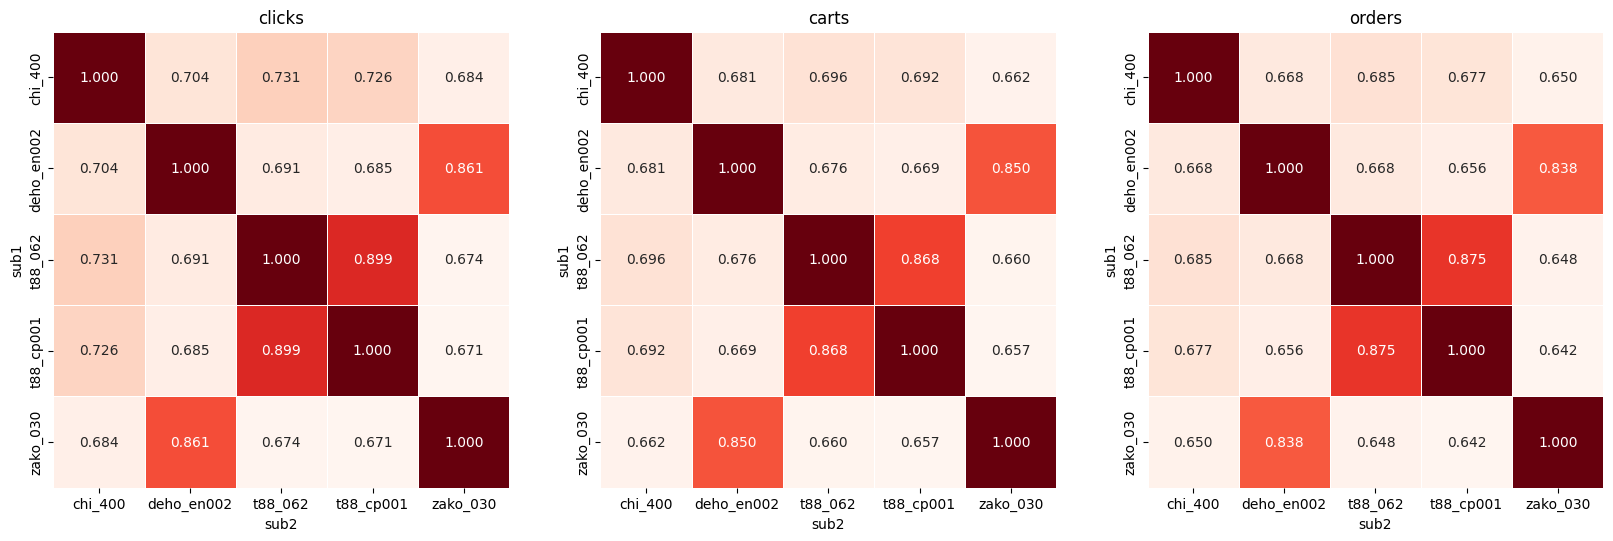

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
for i, type_ in enumerate(["clicks", "carts", "orders"]):
    type_result = result[result["type"]==type_][["sub1", "sub2", "sim"]]
    type_result = pd.pivot(data=type_result, index="sub1", columns="sub2", values="sim")
    sns.heatmap(type_result, annot=True, fmt="1.3f", cmap="Reds", ax=axes[i], square=True, linewidths=0.5, cbar=False)
    axes[i].set_title(type_)